### Welcome to the exercise about observational studies! This exercise will be hands on, and you will be able to practise the skills you developed so far!

## Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 6 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to deepen your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.

In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
%matplotlib inline

data_folder = './data/'
df = pd.read_csv(data_folder + 'lalonde.csv')

In [2]:
df.sample(10)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
53,NSW54,1,25,12,1,0,0,0,0.0000,0.0000,2348.973
289,PSID105,0,21,12,0,0,0,0,2827.2220,4056.8710,5937.505
408,PSID224,0,39,11,0,0,0,1,0.0000,930.9677,0.000
569,PSID385,0,19,12,0,1,0,0,0.0000,0.0000,18573.550
263,PSID79,0,23,17,0,0,0,0,0.0000,4876.8390,16747.080
271,PSID87,0,48,7,0,0,1,1,13326.9300,4636.9350,0.000
539,PSID355,0,19,9,1,0,0,1,384.0163,0.0000,0.000
522,PSID338,0,26,5,0,0,1,1,1573.2910,0.0000,3700.227
415,PSID231,0,18,11,1,0,0,1,587.7800,841.4516,7933.914
72,NSW73,1,18,6,1,0,0,1,0.0000,0.0000,0.000


## 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lecture 4 ("Descibing data") and 3 ("Visualizing data").

What might a naive "researcher" conclude from this superficial analysis?

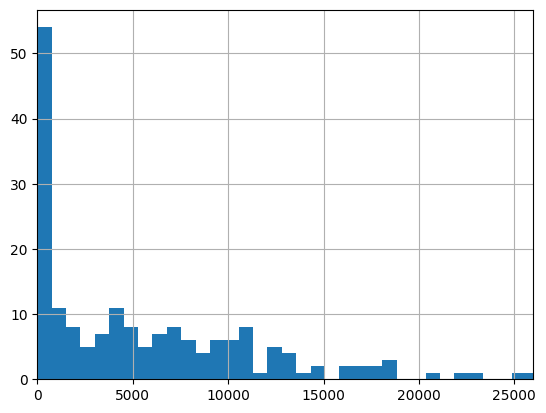

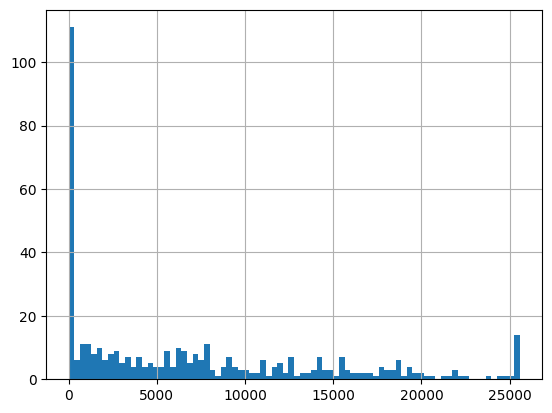

6349.143530270271
6984.169742307692
TtestResult(statistic=-0.966352225446378, pvalue=0.3342496685909654, df=612.0)


In [3]:
''' your code and explanations '''
from scipy import stats
treated = df[df['treat']==1]
control = df[df['treat']==0]

treated['re78'].hist(bins=80)
plt.xlim(0,26000)
plt.show()
control['re78'].hist(bins=80)
plt.show()

print(treated['re78'].mean())
print(control['re78'].mean())

print(stats.ttest_ind(treated['re78'], control['re78']))
# null hypothesis: the two groups have same re78, 

In [4]:
# p > alpha --> accept null hypothesis --> the 2 groups have the same re78

## 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

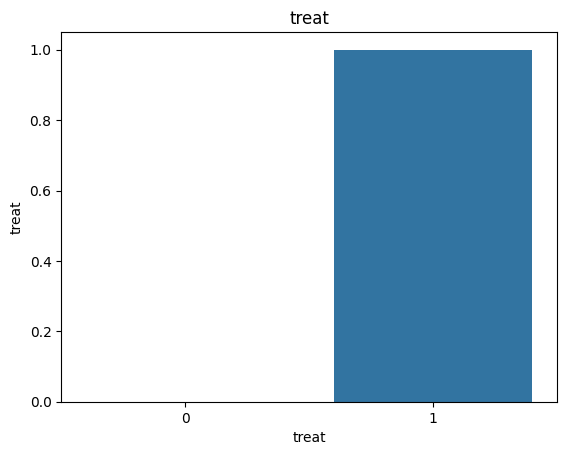

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


treat has different distribution in the two groups


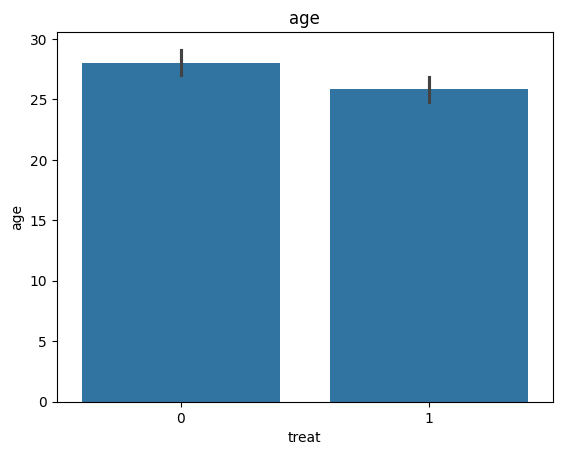

age has different distribution in the two groups


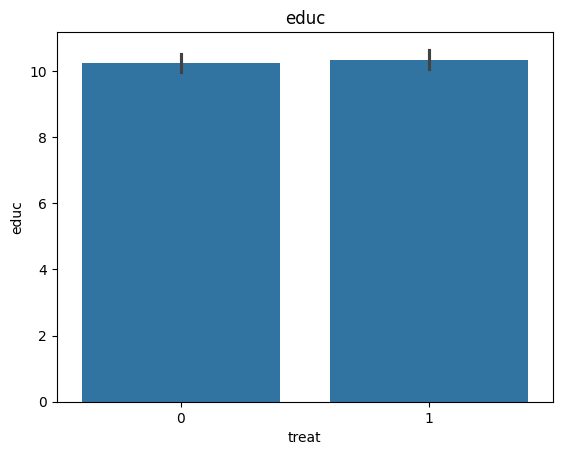

educ has same distribution in the two groups


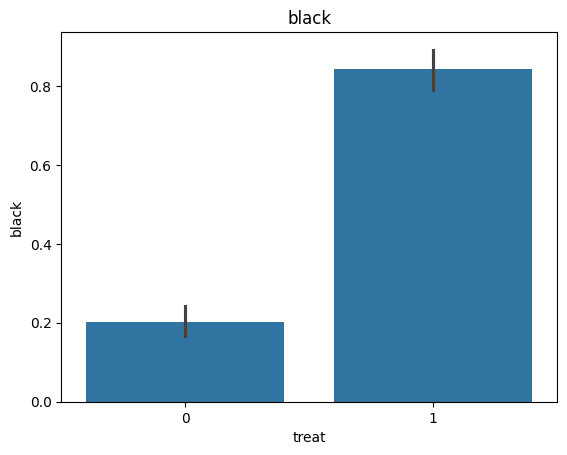

black has different distribution in the two groups


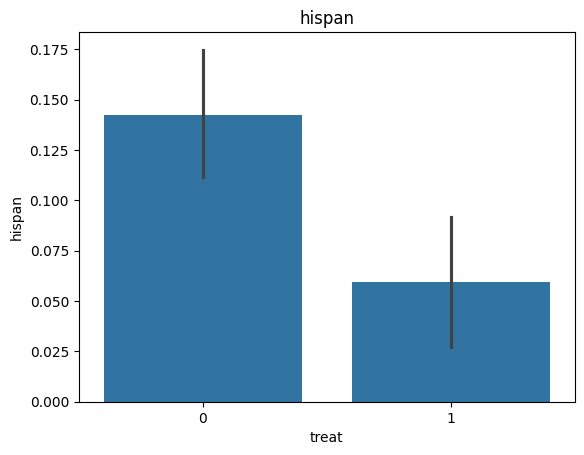

hispan has different distribution in the two groups


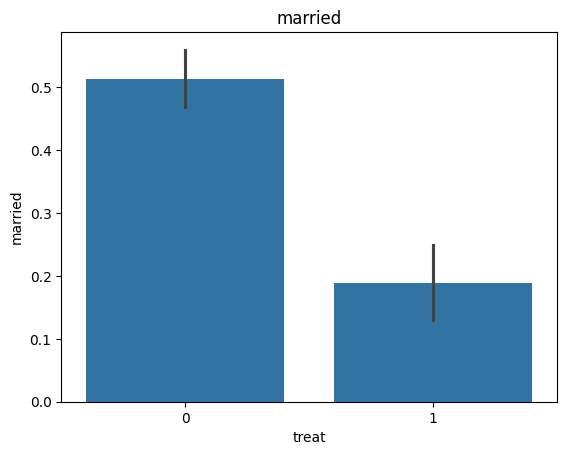

married has different distribution in the two groups


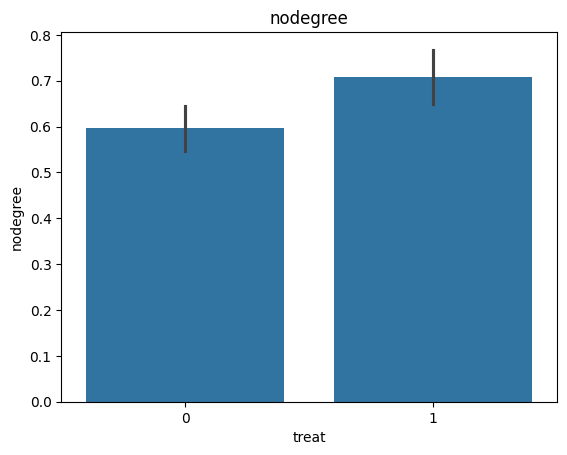

nodegree has different distribution in the two groups


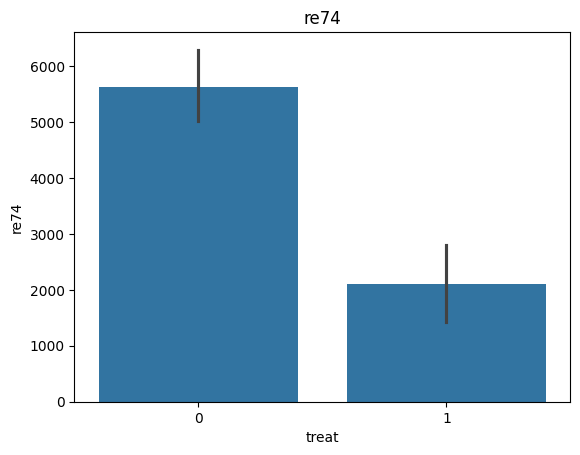

re74 has different distribution in the two groups


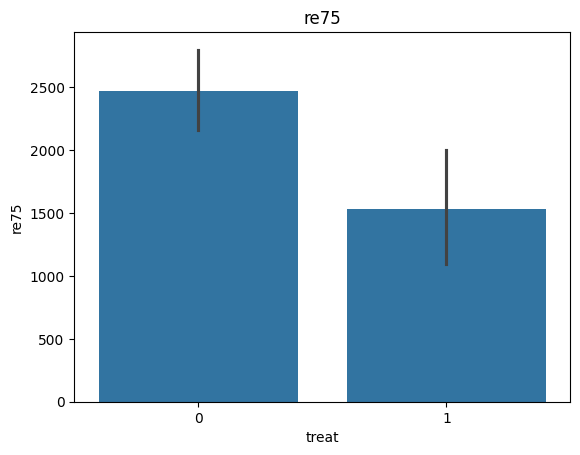

re75 has different distribution in the two groups


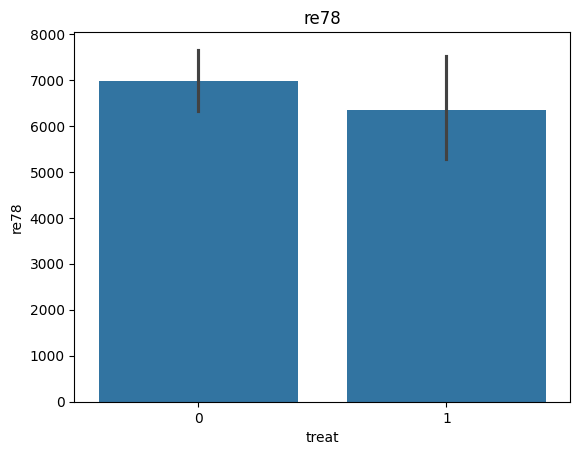

re78 has same distribution in the two groups


In [5]:
''' your code and explanations '''
columns = df.columns
alpha = 0.05

for i in range(1, len(columns)):
    ax = sns.barplot(x="treat", y=columns[i], data=df)
    plt.title(columns[i])
    plt.show()
    t, p = stats.ttest_ind(treated[columns[i]], control[columns[i]])
    if p < alpha:
        print(columns[i], "has different distribution in the two groups")
    else:
        print(columns[i], "has same distribution in the two groups")


<BarContainer object of 2 artists>

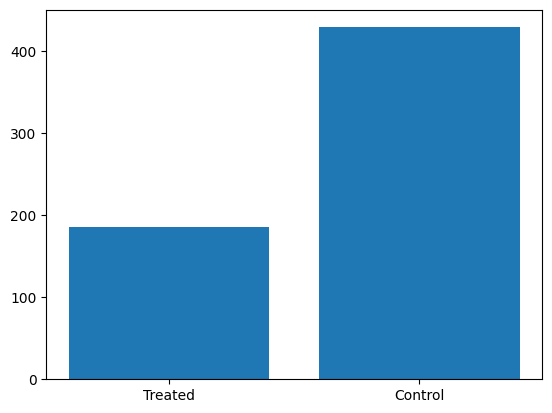

In [6]:
treated_num = len(treated)
control_num = len(control)

groups = ['Treated', 'Control']
counts = [len(treated), len(control)]

# Create the bar plot
plt.bar(groups, counts)

## 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `statsmodels` to fit the logistic regression model and apply it to each data point to obtain propensity scores.

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/pdf/hmbr46-399.pdf).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/pdf/hmbr46-399.pdf).)

In [7]:
df.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


In [8]:
''' your code and explanations '''
import statsmodels.formula.api as smf
df['age'] = (df['age'] - df['age'].mean())/df['age'].std()
df['educ'] = (df['educ'] - df['educ'].mean())/df['educ'].std()
df['re74'] = (df['re74'] - df['re74'].mean())/df['re74'].std()
df['re75'] = (df['re75'] - df['re75'].mean())/df['re75'].std()
mod = smf.ols(formula='treat ~ age + educ + C(black) + C(hispan) + C(married) + C(nodegree) + re74 + re75 + re78', data=df) 
res = mod.fit()
df['propensity_score'] = res.predict()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  treat   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     43.29
Date:                Sun, 05 Jan 2025   Prob (F-statistic):           8.40e-60
Time:                        14:25:28   Log-Likelihood:                -240.05
No. Observations:                 614   AIC:                             500.1
Df Residuals:                     604   BIC:                             544.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0313      0.041  

In [9]:

#sns.kdeplot(df[df['treat'] == 1]['propensity_score'], label='Treated', shade=True)
#sns.kdeplot(df[df['treat'] == 0]['propensity_score'], label='Control', shade=True)
#plt.title('Distribution of Propensity Scores')
#plt.xlabel('Propensity Score')
#plt.ylabel('Density')
#plt.legend()
#plt.show()


## 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

This is how networkx library can help you do this. Each possible pair of (treated_person, control_person) is characterized by a similarity. This is how we can initialize a graph, and add an edge for one possible pair. We then need to add an edge for each possible pair.
    - G = nx.Graph()
    - G.add_weighted_edges_from([(control_person, treated_person, similarity)])
Optimal matching is then found with:
    - matching = nx.max_weight_matching(G)

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?

In [10]:
def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

In [11]:
''' your code and explanations '''
G = nx.Graph()

control = df[df['treat']==0]
treated = df[df['treat']==1]

for t in range(treated.shape[0]):
    for c in range(control.shape[0]):
        control_person = control.iloc[c]
        treated_person = treated.iloc[t]
        similarity = get_similarity(treated_person['propensity_score'], control_person['propensity_score'])
        G.add_weighted_edges_from([(c, t, similarity)])

matching = nx.max_weight_matching(G)

In [12]:
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]

In [13]:
df_balanced = df.iloc[matched]

In [14]:
df_balanced

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity_score
149,NSW150,1,-0.745173,-0.102244,1,0,0,1,0.069186,0.179756,5615.1890,0.659775
130,NSW131,1,-1.048780,-0.482714,1,0,0,1,-0.438569,-0.282643,5445.2000,0.654153
427,PSID243,0,-0.643970,1.419638,0,0,0,0,0.795099,-0.482617,2256.4880,0.053973
277,PSID93,0,-0.542768,-0.102244,0,0,0,1,1.962257,0.672297,2453.0260,0.034688
290,PSID106,0,0.671661,0.278227,0,0,1,1,-0.703546,0.553872,18133.1800,0.175558
...,...,...,...,...,...,...,...,...,...,...,...,...
226,PSID42,0,-0.239161,-2.004596,0,0,1,1,0.514727,1.550162,14617.6700,-0.017859
270,PSID86,0,-0.846375,-0.102244,0,0,0,1,0.188382,0.754868,135.9508,0.103693
271,PSID87,0,2.088495,-1.243655,0,0,1,1,1.353725,0.744004,0.0000,-0.040279
266,PSID82,0,-0.239161,0.658697,0,1,1,0,0.646595,0.782030,379.7757,0.025768


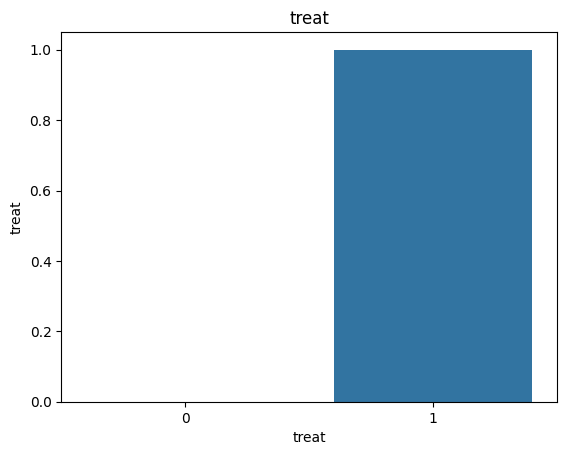

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


treat has different distribution in the two groups


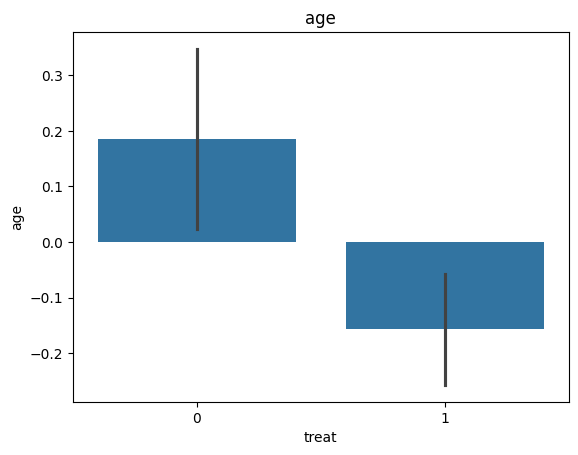

age has different distribution in the two groups


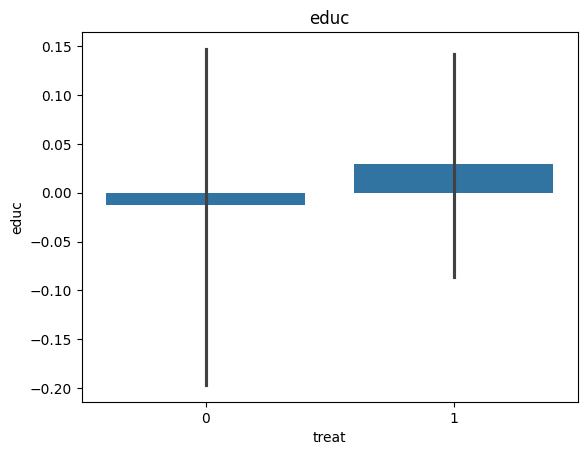

educ has same distribution in the two groups


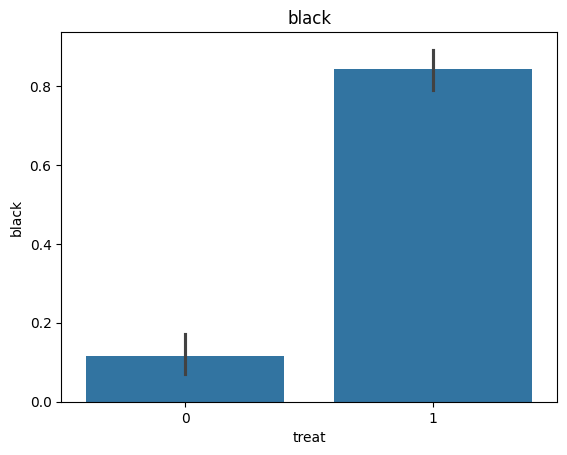

black has different distribution in the two groups


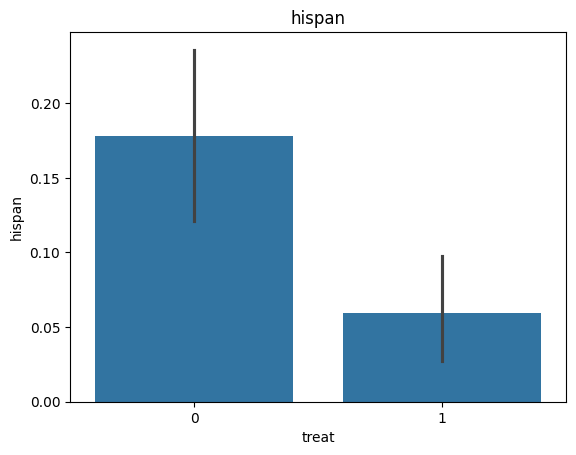

hispan has different distribution in the two groups


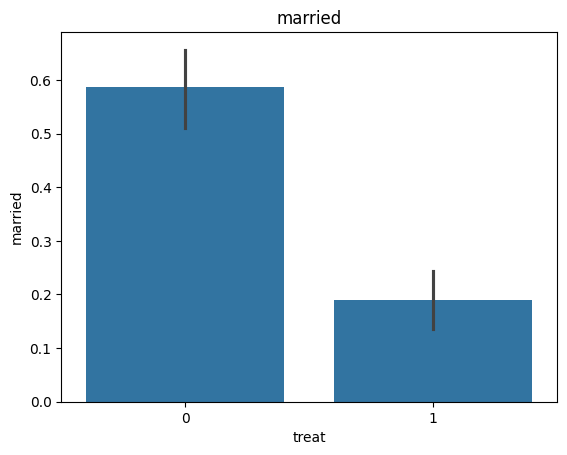

married has different distribution in the two groups


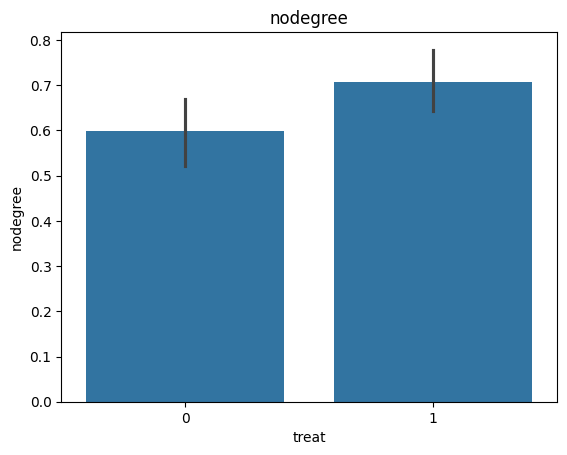

nodegree has different distribution in the two groups


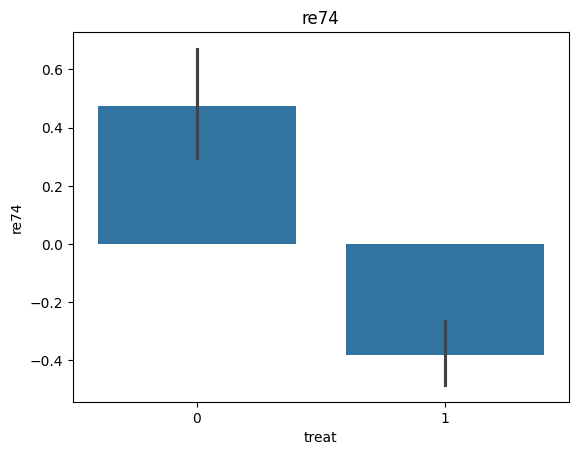

re74 has different distribution in the two groups


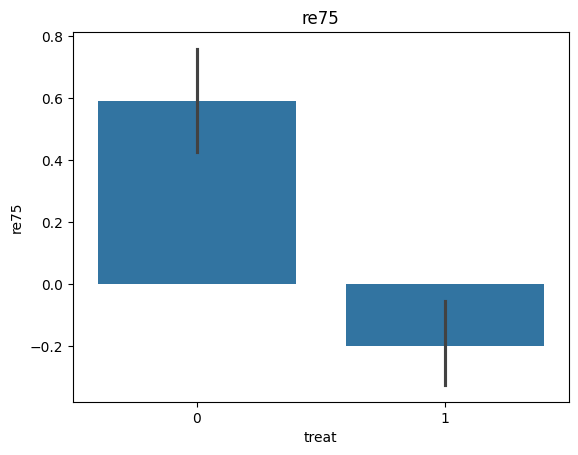

re75 has different distribution in the two groups


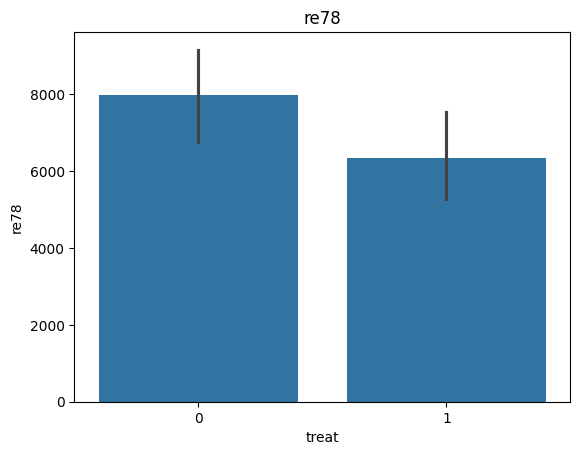

re78 has same distribution in the two groups


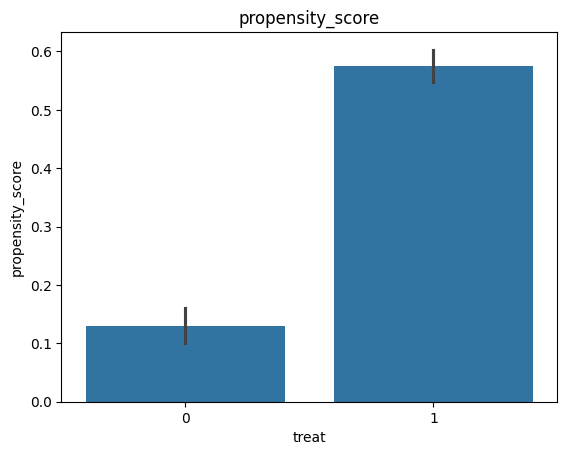

propensity_score has different distribution in the two groups


<BarContainer object of 2 artists>

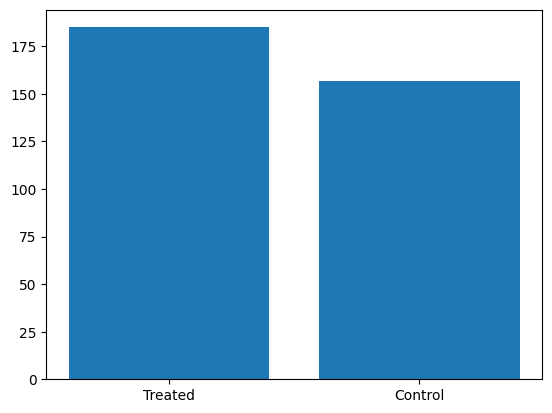

In [15]:
''' your code and explanations ''';
columns_new = df_balanced.columns
treated_new = df_balanced[df_balanced['treat'] ==1]
control_new = df_balanced[df_balanced['treat'] ==0]
for i in range(1, len(columns_new)):
    ax = sns.barplot(x="treat", y=columns_new[i], data=df_balanced)
    plt.title(columns_new[i])
    plt.show()

    t, p = stats.ttest_ind(treated_new[columns_new[i]], control_new[columns_new[i]])
    if p < alpha:
        print(columns_new[i], "has different distribution in the two groups")
    else:
        print(columns_new[i], "has same distribution in the two groups")

groups = ['Treated', 'Control']
counts = [len(treated_new), len(control_new)]

# Create the bar plot
plt.bar(groups, counts)

## 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.


In [16]:
treatment_df = df[df['treat'] == 1]
control_df = df[df['treat'] == 0]


G = nx.Graph()

for control_id, control_row in control_df.iterrows():
    for treatment_id, treatment_row in treatment_df.iterrows():

        # Adds an edge only if the individuals have the same race
        if (control_row['black'] == treatment_row['black'])\
            and (control_row['hispan'] == treatment_row['hispan']):
            similarity = get_similarity(control_row['propensity_score'],
                                        treatment_row['propensity_score'])

            G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

matching = nx.max_weight_matching(G)

In [17]:
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
df_balanced_all = df.iloc[matched]

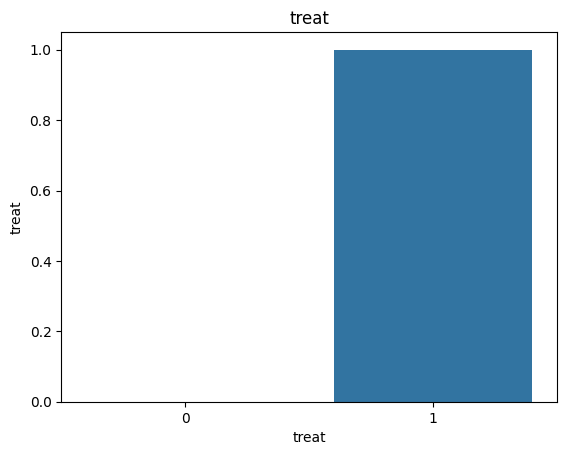

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


treat has different distribution in the two groups


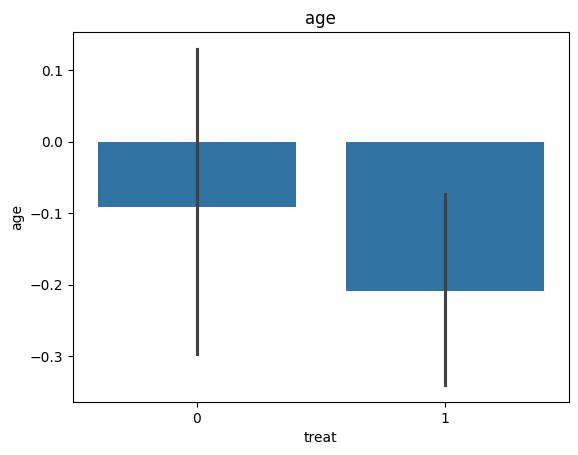

age has same distribution in the two groups


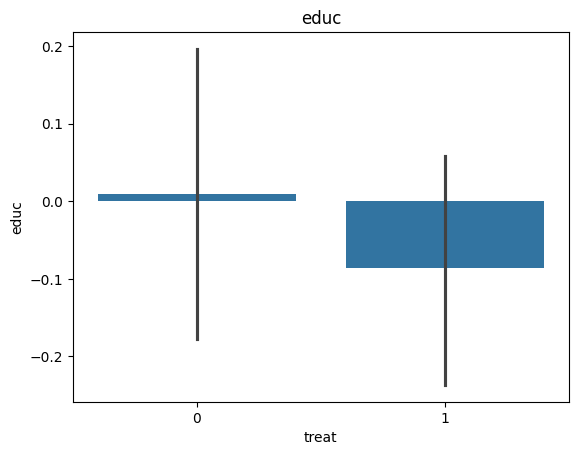

educ has same distribution in the two groups


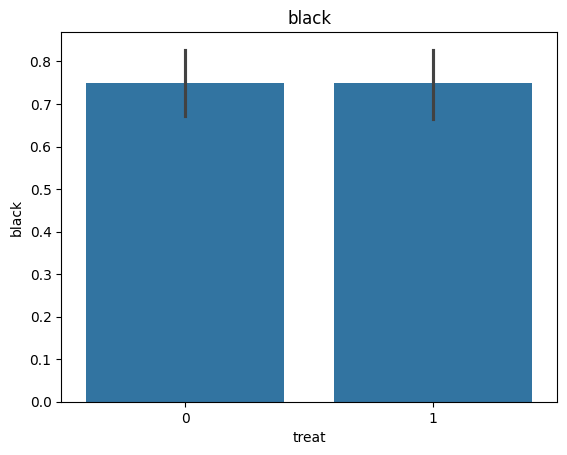

black has same distribution in the two groups


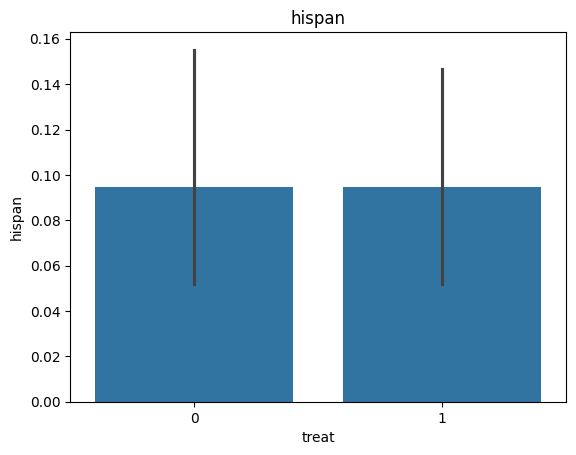

hispan has same distribution in the two groups


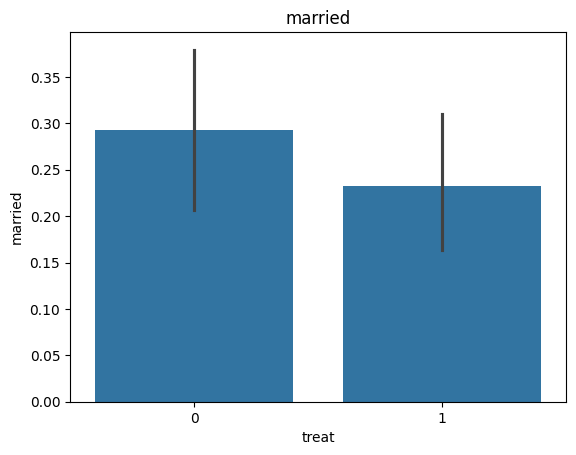

married has same distribution in the two groups


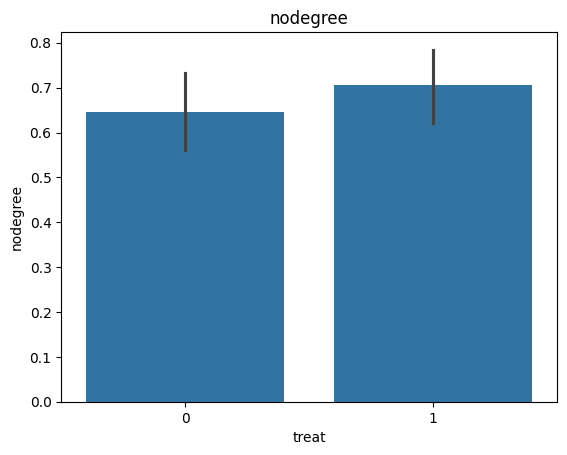

nodegree has same distribution in the two groups


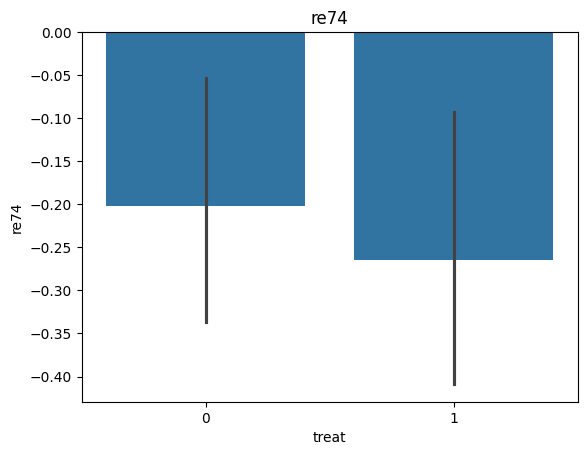

re74 has same distribution in the two groups


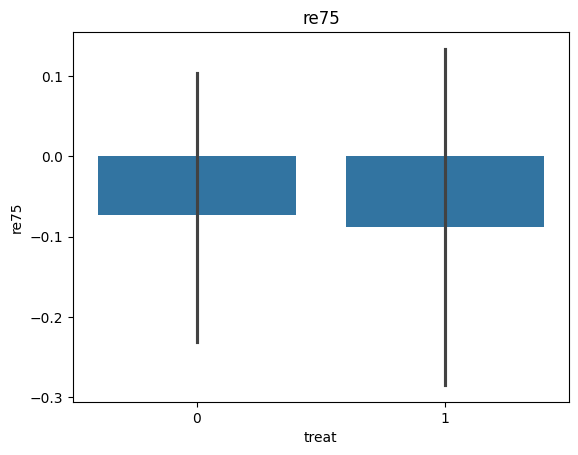

re75 has same distribution in the two groups


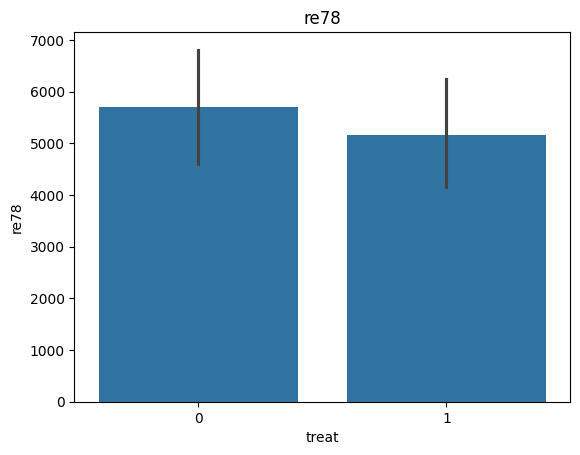

re78 has same distribution in the two groups


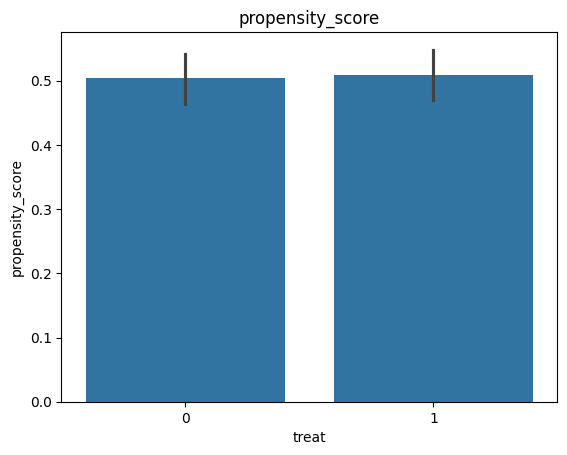

propensity_score has same distribution in the two groups


<BarContainer object of 2 artists>

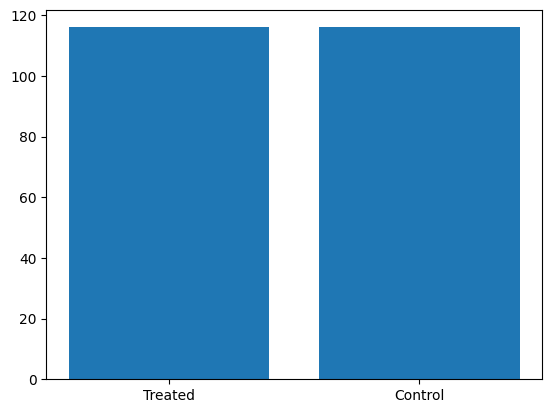

In [18]:
columns_new = df_balanced_all.columns
treated_new = df_balanced_all[df_balanced_all['treat'] ==1]
control_new = df_balanced_all[df_balanced_all['treat'] ==0]
for i in range(1, len(columns_new)):
    ax = sns.barplot(x="treat", y=columns_new[i], data=df_balanced_all)
    plt.title(columns_new[i])
    plt.show()

    t, p = stats.ttest_ind(treated_new[columns_new[i]], control_new[columns_new[i]])
    if p < alpha:
        print(columns_new[i], "has different distribution in the two groups")
    else:
        print(columns_new[i], "has same distribution in the two groups")

groups = ['Treated', 'Control']
counts = [len(treated_new), len(control_new)]

# Create the bar plot
plt.bar(groups, counts)

## 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?

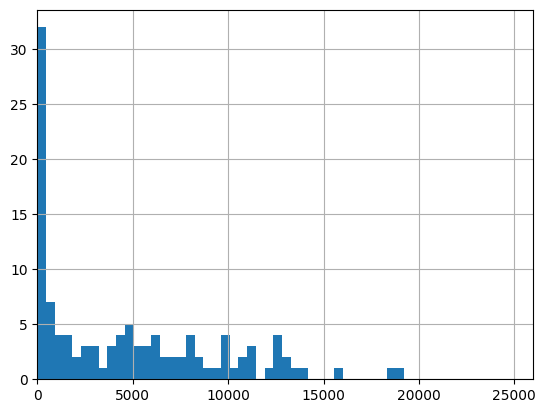

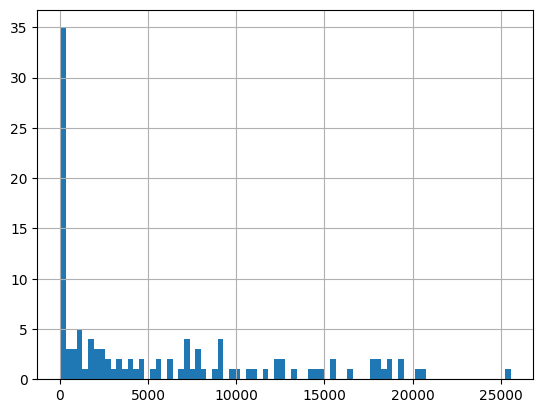

5160.928822413794
5703.476674568966
TtestResult(statistic=-0.966352225446378, pvalue=0.3342496685909654, df=612.0)


In [19]:
''' your code and explanations ''';

treated_new['re78'].hist(bins=80)
plt.xlim(0,26000)
plt.show()
control_new['re78'].hist(bins=80)
plt.show()

print(treated_new['re78'].mean())
print(control_new['re78'].mean())

print(stats.ttest_ind(treated['re78'], control['re78']))